In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
sys.path.insert(0, os.path.abspath('/home/gaspar/git/pyha'))

# Overview
Moving average is useful construct:

- It is a matched filter for rectangular pulses (demodulators make use of this)
- Cheap low pass filter for reducing noise
- High window length can yield DC component of a signal

# Model
Moving average filter can be implemented as a FIR filter, here is an example for
window length of 4.

In [2]:
window_len = 8
taps = [1 / window_len] * window_len
taps

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

To demonstrate the effect of this filter lets make a noisy sine wave and use the filer on it:

<IPython.core.display.Javascript object>


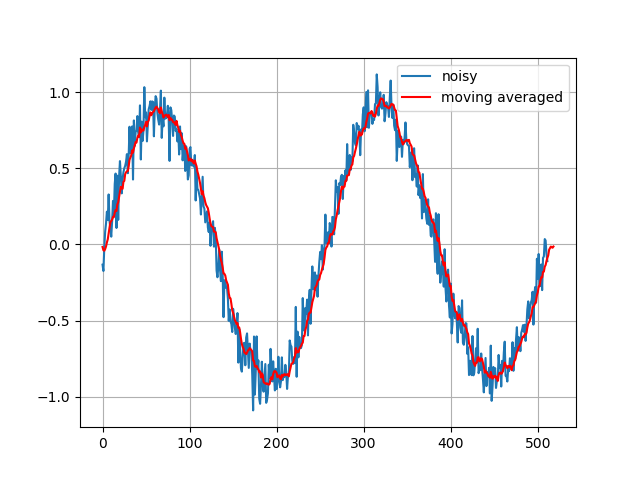

In [7]:
x = np.linspace(0,2*2*np.pi,512)
y = 0.9*np.sin(x)
noise = 0.1*np.random.normal(size=512)
y += noise

filt = np.convolve(y, taps, mode='full') # filter
plt.plot(y, label='noisy')
plt.plot(filt, color='red', label='moving averaged')
plt.legend()
plt.grid()
plt.show()

## Pyha implementation
For model we are just using the same as above. Hardware implementation in the 'main' function uses algorithm well described here: https://www.dsprelated.com/showarticle/58.php
We are going to restrict the window_len to be a power of 2, because this helps hardware implementation.

** NB! Standard work-flow is you define your unit tests on the model and only then implement hardware convertable version. Here we kind of rush ahead and define both at the same time.**

In [4]:
from pyha.simulation.simulation_interface import SIM_MODEL, SIM_HW_MODEL, SIM_RTL, SIM_GATE
simulations = [SIM_MODEL]

In [5]:
from pyha.common.const import Const
from pyha.common.hwsim import HW
from pyha.common.sfix import Sfix, left_index, right_index
from pyha.common.sfix import resize
from pyha.common.util import is_power2


class MovingAverage(HW):
    def __init__(self, window_len):
        if window_len < 2:
            raise AttributeError('Window length must be >= 2')

        if not is_power2(window_len):
            raise AttributeError('Window length must be power of 2')

        self.window_len = window_len
        

        # registers
        # Sfix() -> bounds will be derived from simulation
        self.shift_register = [Sfix()] * self.window_len
        self.sum = Sfix()
        
        # constants
        self.window_pow = Const(int(np.log2(window_len)))
        
        # module delay
        self._delay = 1
        
    def main(self, x):
        """ Hardware model of moving average """
        # add new element to shift register
        self.next.shift_register = [x] + self.shift_register[:-1]
        
        # calculate new sum
        nsum = self.sum + x - self.shift_register[-1]
        
        # resize sum, overflow is impossible
        self.next.sum = resize(nsum, left_index=self.window_pow + left_index(x), right_index=right_index(x))
        
        # divide sum by amout of window_len, and resize to same format as input 'x'
        ret = resize(self.sum >> self.window_pow, size_res=x)
        return ret


    def model_main(self, inputs):
        taps = [1 / self.window_len] * self.window_len
        ret = np.convolve(inputs, taps, mode='full')
        return ret[:-self.window_len + 1]
    
def test_noisy_signal():
    np.random.seed(0)
    mov = MovingAverage(window_len=8)
    y = 0.7 * np.sin(np.linspace(0, 2 * 2 * np.pi, 512))
    noise = 0.1 * np.random.normal(size=512)
    y += noise


    assert_sim_match(mov, [Sfix(left=0, right=-17)],
                     None, # expected = output of model simulation, if None
                     y, # inputs to the model
                     rtol=1e-2, # meaning ~4 digits after decimal must match
                     simulations=simulations
                    )

In [6]:
simulations = [SIM_MODEL, SIM_HW_MODEL]
test_noisy_signal()

NameError: name 'assert_sim_match' is not defined


Make more unit tests!

# RTL and GATE simulations
** These cannot run in Ipython notebook, run them in PyCharm for example **

You need GHDL and Cocotb installed for this step.
We can add RTL simulations by just adding the SIM_RTL to simulations list.

In [ ]:
simulations = [SIM_MODEL, SIM_HW_MODEL, SIM_RTL, SIM_GATE]

You can take a look at converted VHDL files [here](vhdl sources).

Quartus project is here.
